In [1]:
import sys
sys.path.append("..") # Ensure the parent directory is in the path

import core.models as Models
import core
from core.DataLoader import DataPreprocessor, DataConfig
import core.AssignmentKFold as KFold
import numpy as np
from importlib import reload
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
MAX_JETS = 4
PLOTS_DIR = f"plots/"
import os
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

config = DataConfig(jet_features=["ordered_jet_pt", "ordered_jet_e", "ordered_jet_phi", "ordered_jet_eta", "ordered_jet_b_tag"], 
                                lepton_features=["lep_pt","lep_e", "lep_eta", "lep_phi"],
                                jet_truth_label="ordered_event_jet_truth_idx", 
                                lepton_truth_label="event_lepton_truth_idx", 
                                global_features = ["met_met_NOSYS","met_phi_NOSYS"], 
                                max_leptons=2, 
                                max_jets = MAX_JETS, 
                                non_training_features= ["truth_ttbar_mass", "truth_ttbar_pt", "N_jets"], 
                                event_weight="weight_mc_NOSYS")

DataProcessor = DataPreprocessor(config)
DataProcessor.load_data("/data/dust/group/atlas/ttreco/full_training.root", "reco", max_events=1000000)
DataProcessor.normalise_data()
DataProcessor.split_data(0.2)

2025-09-17 15:43:49.067781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 15:43:49.068322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 15:43:49.115707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-17 15:43:50.603612: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [ ]:

reload(KFold)
reload(Models)
TransformerMatcher = Models.FeatureConcatRNN(DataProcessor); TransformerMatcher.load_data(*DataProcessor.get_data())
TransformerMatcher.build_model(
    hidden_dim=64,
    num_layers=4,
    dropout_rate=0.1
)
TransformerMatcher.compile_model(
    lambda_excl=0, optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
)
TransformerMatcher.model.summary()
TransformerMatcher.load_data(*DataProcessor.get_data())

2025-09-17 15:44:22.168188: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "FeatureConcatRNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ global_inputs       │ (None, 1, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_inputs          │ (None, 2, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ global_inputs[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ lep_inputs[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_inputs          │ (None, 4, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 4, 2)      │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 4, 8)      │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 15)     │          0 │ jet_inputs[0][0], │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding (MLP) │ (None, 4, 64)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_mask            │ (None, 4, 1)      │          0 │ jet_inputs[0][0]  │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 4, 128)    │     66,048 │ jet_embedding[0]… │
│ (Bidirectional)     │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_ln_0            │ (None, 4, 128)    │        256 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 4, 128)    │     98,816 │ rnn_ln_0[0][0],   │
│ (Bidirectional)     │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_ln_1            │ (None, 4, 128)    │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 4, 128)    │     98,816 │ rnn_ln_1[0][0],   │
│ (Bidirectional)     │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_ln_2            │ (None, 4, 128)    │        256 │ bidirectional_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 4, 128)    │     98,816 │ rnn_ln_2[0][0],   │
│ (Bidirectional)     │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 363,520 (1.39 MB)

 Trainable params: 363,520 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
TransformerMatcher.train_model(epochs=100,
                                batch_size=512,
                                verbose=1,
                                weight = "sample",
                                callbacks = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=50, restore_best_weights=True, mode ="max"))


Starting training...
Epoch 1/100


2025-09-17 15:44:33.696044: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1555/1555 ━━━━━━━━━━━━━━━━━━━━ 255s 157ms/step - accuracy: 0.7259 - loss: 1.9586 - val_accuracy: 0.6479 - val_loss: 1.6974
Epoch 2/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 245s 157ms/step - accuracy: 0.6663 - loss: 1.7325 - val_accuracy: 0.6786 - val_loss: 1.4849
Epoch 3/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 240s 154ms/step - accuracy: 0.7021 - loss: 1.5960 - val_accuracy: 0.7302 - val_loss: 1.2890
Epoch 4/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 240s 154ms/step - accuracy: 0.7345 - loss: 1.4812 - val_accuracy: 0.7596 - val_loss: 1.2225
Epoch 5/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 243s 156ms/step - accuracy: 0.7425 - loss: 1.4250 - val_accuracy: 0.7472 - val_loss: 1.1768
Epoch 6/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 246s 158ms/step - accuracy: 0.7501 - loss: 1.3900 - val_accuracy: 0.7379 - val_loss: 1.1536
Epoch 7/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 246s 158ms/step - accuracy: 0.7507 - loss: 1.3636 - val_accuracy: 0.7817 - val_loss: 1.1291
Epoch 8/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 244s 157ms/step - accura

KeyboardInterrupt: 

In [ ]:
TransformerMatcher.plot_history()

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Confusion Matrix for Lepton 1 (Bootstrap)'}, xlabel='Predicted Label', ylabel='True Label'>,
        <Axes: title={'center': 'Confusion Matrix for Lepton 2 (Bootstrap)'}, xlabel='Predicted Label', ylabel='True Label'>],
       dtype=object))

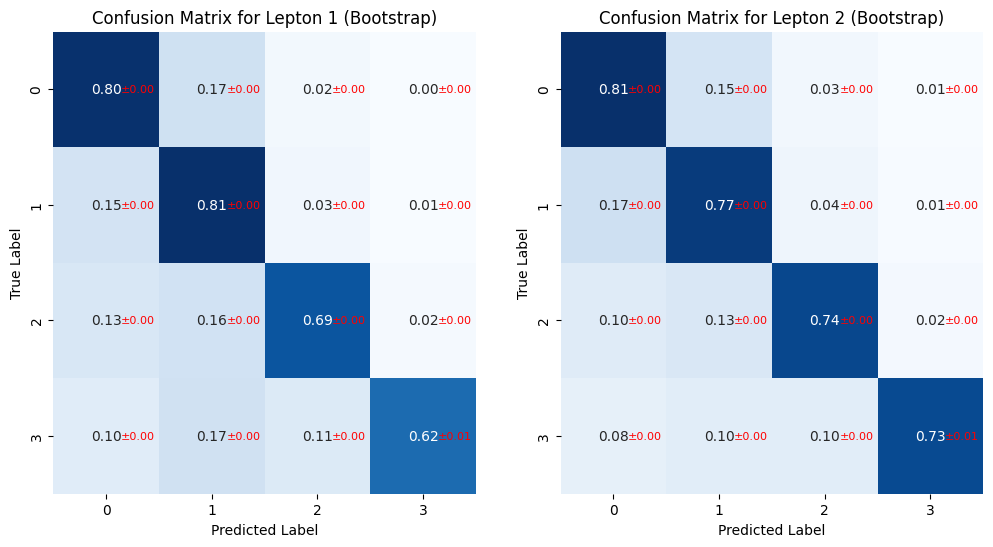

In [4]:
TransformerMatcher.plot_confusion_matrix()

In [ ]:
TransformerMatcher.plot_permutation_importance(shuffle_number=5)